In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from pathlib import Path
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from MCForecastTools import MCSimulation

In [2]:
load_dotenv()

True

### Data Preparation

In [3]:
Td_data = pd.read_csv("Stock Data - TSE_TD.csv",  index_col="Date")
Bmo_data = pd.read_csv("Stock Data - TSE_BMO (1).csv",index_col="Date")
RY_data = pd.read_csv("Stock Data - TSE_RY (1).csv", index_col="Date")
BNS_data = pd.read_csv("Stock Data - TSE_BNS (2).csv", index_col="Date")
SP500_data = pd.read_csv("Stock Data - S&P 500 (1).csv",index_col="Date")

In [4]:
Stock_concat = pd.concat([Td_data, Bmo_data, RY_data, BNS_data, SP500_data], axis=1, join="inner", keys=["TD", "BMO", "RY", "BNS", "S&P 500"]).dropna().reset_index()

# Sort datetime index in ascending order (past to present)
Stock_concat = Stock_concat.sort_index()

# Display a few rows
Stock_concat.head()

,Date,TD,BMO,RY,BNS,S&P 500
,,Close,Close,Close,Close,Close
0,04/01/2016 16:00:00,53.72,76.66,73.04,55.54,2012.66
1,05/01/2016 16:00:00,53.51,76.62,72.82,56.13,2016.71
2,07/01/2016 16:00:00,51.03,73.52,70.25,54.31,1943.09
3,11/01/2016 16:00:00,51.39,73.61,70.41,54.19,1923.67
4,12/01/2016 16:00:00,52.40,74.18,70.92,54.05,1938.68


In [5]:
Stock_concat1 = pd.concat([Td_data, Bmo_data, RY_data, BNS_data, SP500_data], axis=1, join="inner")
Stock_concat1

,Close,Close,Close,Close,Close
Date,,,,,
04/01/2016 16:00:00,53.72,76.66,73.04,55.54,2012.66
05/01/2016 16:00:00,53.51,76.62,72.82,56.13,2016.71
07/01/2016 16:00:00,51.03,73.52,70.25,54.31,1943.09
11/01/2016 16:00:00,51.39,73.61,70.41,54.19,1923.67
12/01/2016 16:00:00,52.40,74.18,70.92,54.05,1938.68
...,...,...,...,...,...
21/12/2021 16:00:00,94.70,133.14,131.57,87.69,4649.23
22/12/2021 16:00:00,95.41,135.35,132.59,88.67,4696.56
23/12/2021 16:00:00,96.21,135.58,133.64,89.31,4725.79


In [6]:
Stock_concat1.columns= ['TD', 'BMO', 'RY', 'BNS', 'SP500']
Stock_concat1

,TD,BMO,RY,BNS,SP500
Date,,,,,
04/01/2016 16:00:00,53.72,76.66,73.04,55.54,2012.66
05/01/2016 16:00:00,53.51,76.62,72.82,56.13,2016.71
07/01/2016 16:00:00,51.03,73.52,70.25,54.31,1943.09
11/01/2016 16:00:00,51.39,73.61,70.41,54.19,1923.67
12/01/2016 16:00:00,52.40,74.18,70.92,54.05,1938.68
...,...,...,...,...,...
21/12/2021 16:00:00,94.70,133.14,131.57,87.69,4649.23
22/12/2021 16:00:00,95.41,135.35,132.59,88.67,4696.56
23/12/2021 16:00:00,96.21,135.58,133.64,89.31,4725.79


In [7]:
Stock_concat1.describe()

,TD,BMO,RY,BNS,SP500
count,1466.000000,1466.000000,1466.000000,1466.000000,1466.000000
mean,70.401985,97.068022,99.543247,72.003015,2946.422306
std,9.777426,15.579969,14.196212,8.477017,714.147193
min,49.020000,56.240000,65.000000,46.720000,1829.080000
25%,63.210000,86.272500,92.972500,68.262500,2432.480000
50%,72.360000,97.720000,99.645000,74.470000,2797.915000
75%,75.917500,102.417500,105.197500,78.110000,3274.375000
max,97.510000,140.270000,134.790000,91.260000,4793.060000


In [8]:
Stock_concat1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1466 entries, 04/01/2016 16:00:00 to 30/12/2021 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TD      1466 non-null   float64
 1   BMO     1466 non-null   float64
 2   RY      1466 non-null   float64
 3   BNS     1466 non-null   float64
 4   SP500   1466 non-null   float64
dtypes: float64(5)
memory usage: 68.7+ KB


## Evaluate the Riskiness of Stocks

In [9]:
volatility = Stock_concat1.std() * np.sqrt(252)

In [10]:
volatility = volatility.sort_values()
volatility

BNS        134.568478
TD         155.211827
RY         225.357877
BMO        247.324342
SP500    11336.735237
dtype: float64

## Daily returns of the stock

In [11]:
daily_returns = Stock_concat1.pct_change().dropna()
daily_returns

,TD,BMO,RY,BNS,SP500
Date,,,,,
05/01/2016 16:00:00,-0.003909,-0.000522,-0.003012,0.010623,0.002012
07/01/2016 16:00:00,-0.046346,-0.040459,-0.035293,-0.032425,-0.036505
11/01/2016 16:00:00,0.007055,0.001224,0.002278,-0.002210,-0.009994
12/01/2016 16:00:00,0.019654,0.007744,0.007243,-0.002584,0.007803
13/01/2016 16:00:00,-0.017176,-0.029388,-0.024958,-0.019426,-0.024965
...,...,...,...,...,...
21/12/2021 16:00:00,0.007661,0.012164,0.012155,0.009904,0.017778
22/12/2021 16:00:00,0.007497,0.016599,0.007753,0.011176,0.010180
23/12/2021 16:00:00,0.008385,0.001699,0.007919,0.007218,0.006224


In [12]:
Stock_concat1.isnull().mean() * 100

TD       0.0
BMO      0.0
RY       0.0
BNS      0.0
SP500    0.0
dtype: float64

In [13]:
Stock_concat1.isnull().sum()

TD       0
BMO      0
RY       0
BNS      0
SP500    0
dtype: int64

In [14]:
correlation = daily_returns.corr()
correlation

,TD,BMO,RY,BNS,SP500
TD,1.000000,0.840366,0.850373,0.848832,0.687715
BMO,0.840366,1.000000,0.825647,0.837803,0.681616
RY,0.850373,0.825647,1.000000,0.832870,0.714775
BNS,0.848832,0.837803,0.832870,1.000000,0.658362
SP500,0.687715,0.681616,0.714775,0.658362,1.000000


## Plot Correlation

<AxesSubplot:>

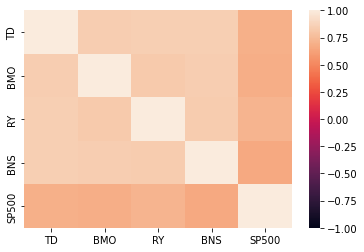

In [15]:
# Create a heatmap from the correlation values and adjust the scale
sns.heatmap(correlation, vmin=-1, vmax=1) 

## Calculate 20-Day Simple Moving Average (SMA20)


In [16]:
sma20 = Stock_concat1.rolling(window=20).mean()
sma20.dropna()

,TD,BMO,RY,BNS,SP500
Date,,,,,
03/02/2016 16:00:00,51.5275,73.3440,69.5400,54.3715,1914.8005
04/02/2016 16:00:00,51.4730,73.2365,69.4375,54.4375,1909.9400
05/02/2016 16:00:00,51.4175,73.1220,69.3535,54.4710,1903.1070
08/02/2016 16:00:00,51.4415,73.1225,69.3055,54.5395,1898.6245
09/02/2016 16:00:00,51.3860,73.0185,69.1670,54.5385,1895.0515
...,...,...,...,...,...
21/12/2021 16:00:00,94.5380,136.8745,129.7160,84.8210,4640.2255
22/12/2021 16:00:00,94.6605,136.7115,129.7640,85.1385,4640.9065
23/12/2021 16:00:00,94.7100,136.4980,129.8625,85.4340,4642.6610


## Calculate 50-Day Simple Moving Average (SMA50)

In [17]:
sma50 = Stock_concat1.rolling(window=50).mean()
sma50.dropna()

,TD,BMO,RY,BNS,SP500
Date,,,,,
17/03/2016 16:00:00,52.3528,74.3554,70.2418,56.2274,1933.4610
18/03/2016 16:00:00,52.3860,74.3944,70.2854,56.3880,1934.1994
21/03/2016 16:00:00,52.4294,74.4428,70.3354,56.5386,1934.8972
22/03/2016 16:00:00,52.5158,74.5456,70.4262,56.7204,1937.0314
23/03/2016 16:00:00,52.5988,74.6470,70.5168,56.9020,1939.2922
...,...,...,...,...,...
21/12/2021 16:00:00,91.8448,136.5010,130.7542,82.9794,4609.4954
22/12/2021 16:00:00,92.0272,136.5940,130.8378,83.1854,4615.5998
23/12/2021 16:00:00,92.2376,136.7126,130.9446,83.4010,4623.1026


## Calculate 50-Day Simple Moving Average (SMA50)

In [18]:
sma100 = Stock_concat1.rolling(window=100).mean()
sma100.dropna()

,TD,BMO,RY,BNS,SP500
Date,,,,,
01/06/2016 16:00:00,54.1268,77.5936,73.4706,59.8595,2000.8136
02/06/2016 16:00:00,54.1654,77.6536,73.5364,59.9586,2001.7396
03/06/2016 16:00:00,54.2028,77.7161,73.6008,60.0520,2002.5638
06/06/2016 16:00:00,54.2661,77.8144,73.6916,60.1675,2004.2270
07/06/2016 16:00:00,54.3298,77.9161,73.7870,60.2963,2006.1116
...,...,...,...,...,...
21/12/2021 16:00:00,87.9343,132.0145,129.8541,80.8873,4524.1814
22/12/2021 16:00:00,88.0559,132.1129,129.9136,80.9920,4527.1406
23/12/2021 16:00:00,88.1810,132.2073,129.9800,81.0986,4530.2070


## Overlay Daily Closing Prices of SHOP and SMAs

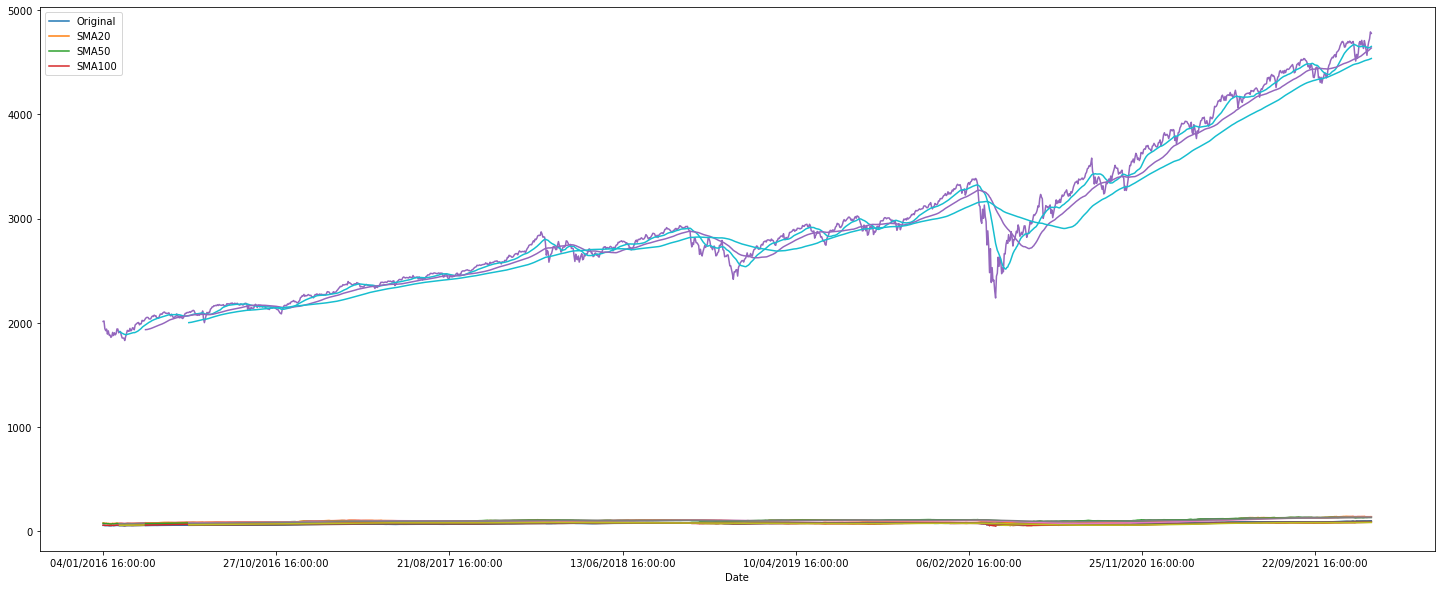

In [19]:
# Set figure of the daily closing prices of SHOP
ax = Stock_concat1.plot(figsize=(25,10))

# Overlay SMA20, SMA50, and SMA100 on the same figure
sma20.plot(ax=ax)
sma50.plot(ax=ax)
sma100.plot(ax=ax)

# Set the legend of the figure
ax.legend(["Original", "SMA20", "SMA50", "SMA100"]);

## Monte Carlo Simulation Forecasting the next 5 years performance of each stocks

In [20]:
MCTd_data = pd.read_csv("Stock Data - TSE_TD.csv",  index_col="Date")
MCBmo_data = pd.read_csv("Stock Data - TSE_BMO (1).csv",index_col="Date")
MCRY_data = pd.read_csv("Stock Data - TSE_RY (1).csv", index_col="Date")
MCBNS_data = pd.read_csv("Stock Data - TSE_BNS (2).csv", index_col="Date")
MCSP500_data = pd.read_csv("Stock Data - S&P 500 (1).csv",index_col="Date")
MCTd_data

,Close
Date,
04/01/2016 16:00:00,53.72
05/01/2016 16:00:00,53.51
06/01/2016 16:00:00,52.18
07/01/2016 16:00:00,51.03
08/01/2016 16:00:00,51.05
...,...
22/12/2021 16:00:00,95.41
23/12/2021 16:00:00,96.21
24/12/2021 13:00:00,96.30


In [21]:
MCTd_data.rename(columns={"Close": "close"}, inplace=True)

In [22]:
MCTd_data

,close
Date,
04/01/2016 16:00:00,53.72
05/01/2016 16:00:00,53.51
06/01/2016 16:00:00,52.18
07/01/2016 16:00:00,51.03
08/01/2016 16:00:00,51.05
...,...
22/12/2021 16:00:00,95.41
23/12/2021 16:00:00,96.21
24/12/2021 13:00:00,96.30


In [23]:
MC_TD = MCSimulation(
    portfolio_data = MCTd_data,
    num_simulation = 1000,
    num_trading_days = 252
)

MC_TD.calc_cumulative_return()

IndexError: Too many levels: Index has only 1 level, not 2